In [1]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)


In [2]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


# Descriptive Statistics

In [4]:
from tableone import TableOne, load_dataset
import pandas as pd

data_filtered = data.drop(['hosdeath_flag'], axis=1)
columns = list(data_filtered.columns.values)
groupby = ['icu_adm_flag']
# nonnormal = ['Age']
mytable = TableOne(data_filtered, columns=columns, groupby=groupby, pval=True)
mytable

/Users/llja0112/anaconda3/envs/medical/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),


Grouped by icu_adm_flag                                                     
                                                                  Missing        Overall              0              1 P-Value
n                                                                                   7690           5623           2067        
gender, n (%)                               0                           0    4101 (53.3)    3093 (55.0)    1008 (48.8)  <0.001
                                            1                                3589 (46.7)    2530 (45.0)    1059 (51.2)        
myocardial_infarct, n (%)                   0                           0    6971 (90.7)    5187 (92.2)    1784 (86.3)  <0.001
                                            1                                  719 (9.3)      436 (7.8)     283 (13.7)        
congestive_heart_failure, n (%)             0                           0    5930 (77.1)    4599 (81.8)    1331 (64.4)  <0.001
                                            1                                1760 (22.9)    1024 (18.2)     736 (35.6)        
peripheral_vascular_disease, n (%)          0                           0    7108 (92.4)    5243 (93.2)    1865 (90.2)  <0.001
                                            1                                  582 (7.6)      380 (6.8)      202 (9.8)        
cerebrovascular_disease, n (%)              0                           0    7073 (92.0)    5236 (93.1)    1837 (88.9)  <0.001
                                            1                                  617 (8.0)      387 (6.9)     230 (11.1)        
dementia, n (%)                             0                           0    7314 (95.1)    5356 (95.3)    1958 (94.7)   0.375
                                            1                                  376 (4.9)      267 (4.7)      109 (5.3)        
chronic_pulmonary_disease, n (%)            0                           0    5569 (72.4)    4225 (75.1)    1344 (65.0)  <0.001
                                            1                                2121 (27.6)    1398 (24.9)     723 (35.0)        
rheumatic_disease, n (%)                    0                           0    7343 (95.5)    5388 (95.8)    1955 (94.6)   0.024
                                            1                                  347 (4.5)      235 (4.2)      112 (5.4)        
peptic_ulcer_disease, n (%)                 0                           0    7577 (98.5)    5554 (98.8)    2023 (97.9)   0.005
                                            1                                  113 (1.5)       69 (1.2)       44 (2.1)        
mild_liver_disease, n (%)                   0                           0    6858 (89.2)    5125 (91.1)    1733 (83.8)  <0.001
                                            1                                 832 (10.8)      498 (8.9)     334 (16.2)        
diabetes_without_cc, n (%)                  0                           0    5874 (76.4)    4381 (77.9)    1493 (72.2)  <0.001
                                            1                                1816 (23.6)    1242 (22.1)     574 (27.8)        
diabetes_with_cc, n (%)                     0                           0    7118 (92.6)    5217 (92.8)    1901 (92.0)   0.249
                                            1                                  572 (7.4)      406 (7.2)      166 (8.0)        
paraplegia, n (%)                           0                           0    7508 (97.6)    5518 (98.1)    1990 (96.3)  <0.001
                                            1                                  182 (2.4)      105 (1.9)       77 (3.7)        
renal_disease, n (%)                        0                           0    5859 (76.2)    4378 (77.9)    1481 (71.6)  <0.001
                                            1                                1831 (23.8)    1245 (22.1)     586 (28.4)        
malignant_cancer, n (%)                     0                           0    6559 (85.3)    4855 (86.3)    1704 (

In [5]:
mytable.to_csv('sepsis_mortality.csv')

# Logistic Regression


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8820026662716635
Average Precision: 0.4157228149040318
Accuracy: 0.9332466406588643


# Gradient Boosting

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators': [60, 80, 120, 140], 
    'max_depth':[1, 3, 5]
}

GBoost = GradientBoostingClassifier(n_estimators=100, max_depth=1, random_state=seed)
clf = GridSearchCV(GBoost, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)


{'max_depth': 3, 'n_estimators': 120}
0.8778955430534378


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=120, max_depth=3, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.9019019404532662
Average Precision: 0.44950917888087466
Accuracy: 0.9345470307758994


# Random Forest

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators': [260, 280, 300, 320], 
    'max_depth':[1,3,5]
}

RanFor = RandomForestClassifier(n_estimators=110, max_depth=7, random_state=seed)
clf = GridSearchCV(RanFor, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 5, 'n_estimators': 260}
0.8751310443942021


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=260, max_depth=5, random_state=seed)
clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.9005214042364095
Average Precision: 0.45050732164899465
Accuracy: 0.9319462505418292


In [15]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


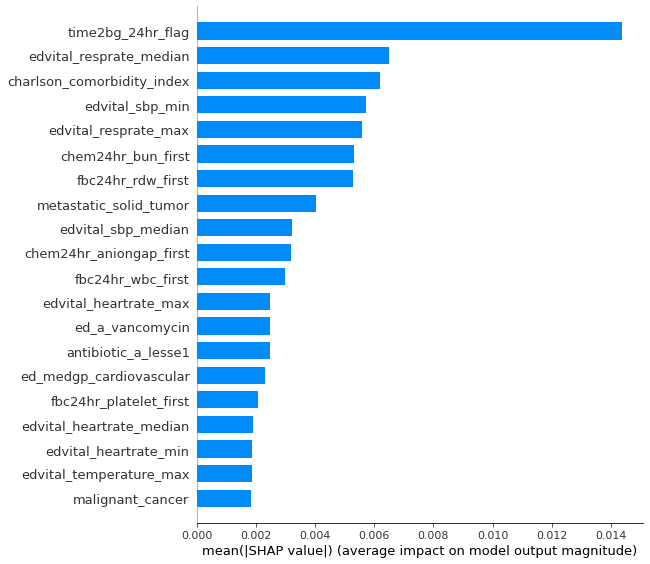

In [16]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

# Neural Networks

In [ ]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

'''
    Define MLP network
'''

class NetSimple(nn.Module):
    def __init__(self):
        super(NetSimple, self).__init__()
        self.fc1 = nn.Linear(113, 100)
        self.fc7 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.fc7(F.selu(x))
        return self.sigmoid(x)
    


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
'''
    Train model
'''
import numpy as np

from scipy.special import expit, logit

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pdb

def train(inputs, labels, net, optimizer):
    running_loss = 0.0
    inputsVariable = Variable(torch.from_numpy(inputs).float())
    labelsVariable = Variable(torch.from_numpy(labels).float())
    
    for t in range(10000):  # loop over the dataset multiple otimes

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputsVariable)
        # pdb.set_trace()
        loss = criterion(outputs.squeeze(), labelsVariable)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if t % 100 == 99:    # print every 50 mini-batches
            print('[%4d] loss: %.3f' %
                  (t + 1, running_loss / 100))
            if running_loss / 100 < 0.1:
                break
            else:
                running_loss = 0.0

    print('Finished Training')


skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train_scaled, y_train)

# net = NetSimple()
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)

index = 0
for train_index, test_index in skf.split(X_train_scaled, y_train):
    print("Cross Validation Fold: " + str(index+1))
    
    net = NetSimple()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr = 0.01)

    train(X_train_scaled[train_index], y_train.iloc[train_index].values, net, optimizer)
    
    print("")
    print('Train Performance')
    
    train_inputs = Variable(torch.from_numpy(X_train_scaled[train_index]).float())
    train_outputs = net(train_inputs)
    
    probs = torch.max(train_outputs.data, 1).values.data.numpy()
    predictions = (probs >= 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_train.iloc[train_index], probs)
    print("ROC AUC: " + str(roc_auc))

    average_precision = average_precision_score(y_train.iloc[train_index], probs)
    print("Average Precision: " + str(average_precision))

    accuracy = accuracy_score(y_train.iloc[train_index], predictions)
    print("Accuracy: " + str(accuracy))

    print(confusion_matrix(y_train.iloc[train_index], predictions))
    
    print("")
    print('Test Performance')
    
    test_inputs = Variable(torch.from_numpy(X_train_scaled[test_index]).float())
    test_outputs = net(test_inputs)
    
    probs = torch.max(test_outputs.data, 1).values.data.numpy()
    predictions = (probs >= 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_train.iloc[test_index], probs)
    print("ROC AUC: " + str(roc_auc))

    average_precision = average_precision_score(y_train.iloc[test_index], probs)
    print("Average Precision: " + str(average_precision))

    accuracy = accuracy_score(y_train.iloc[test_index], predictions)
    print("Accuracy: " + str(accuracy))

    print(confusion_matrix(y_train.iloc[test_index], predictions))
    
    print("")
    print("")
    
    index += 1

Cross Validation Fold: 1
[ 100] loss: 0.643
[ 200] loss: 0.583
[ 300] loss: 0.553
[ 400] loss: 0.535
[ 500] loss: 0.523
[ 600] loss: 0.513
[ 700] loss: 0.506
[ 800] loss: 0.501
[ 900] loss: 0.496
[1000] loss: 0.493
[1100] loss: 0.490
[1200] loss: 0.487
[1300] loss: 0.484
[1400] loss: 0.482
[1500] loss: 0.481
[1600] loss: 0.479
[1700] loss: 0.477
[1800] loss: 0.476
[1900] loss: 0.475
[2000] loss: 0.473
[2100] loss: 0.472
[2200] loss: 0.471
[2300] loss: 0.470
[2400] loss: 0.469
[2500] loss: 0.468
[2600] loss: 0.466
[2700] loss: 0.465
[2800] loss: 0.464
[2900] loss: 0.463
[3000] loss: 0.462
[3100] loss: 0.462
[3200] loss: 0.461
[3300] loss: 0.460
[3400] loss: 0.459
[3500] loss: 0.458
[3600] loss: 0.457
[3700] loss: 0.456
[3800] loss: 0.455
[3900] loss: 0.454
[4000] loss: 0.453
[4100] loss: 0.452
[4200] loss: 0.451
[4300] loss: 0.450
[4400] loss: 0.449
[4500] loss: 0.448
[4600] loss: 0.447
[4700] loss: 0.446
[4800] loss: 0.445
[4900] loss: 0.444
[5000] loss: 0.443
[5100] loss: 0.442
[5200]

[8100] loss: 0.395
[8200] loss: 0.393
[8300] loss: 0.391
[8400] loss: 0.390
[8500] loss: 0.388
[8600] loss: 0.386
[8700] loss: 0.384
[8800] loss: 0.382
[8900] loss: 0.380
[9000] loss: 0.378
[9100] loss: 0.376
[9200] loss: 0.375
[9300] loss: 0.373
[9400] loss: 0.371
[9500] loss: 0.369
[9600] loss: 0.367
[9700] loss: 0.365
[9800] loss: 0.363
[9900] loss: 0.360
[10000] loss: 0.358
Finished Training

Train Performance
ROC AUC: 0.9208461302711973
Average Precision: 0.8950814272702864
Accuracy: 0.8459427675421404
[[1449  132]
 [ 261  709]]

Test Performance
ROC AUC: 0.78880636049796
Average Precision: 0.7160663757154302
Accuracy: 0.7362637362637363
[[327  68]
 [100 142]]


Cross Validation Fold: 5
[ 100] loss: 0.664
[ 200] loss: 0.594
[ 300] loss: 0.560
[ 400] loss: 0.540
[ 500] loss: 0.526
[ 600] loss: 0.517
[ 700] loss: 0.510
[ 800] loss: 0.505
[ 900] loss: 0.501
[1000] loss: 0.498
[1100] loss: 0.495
[1200] loss: 0.493
[1300] loss: 0.491
[1400] loss: 0.489
[1500] loss: 0.487
[1600] loss: 0

In [5]:
net = NetSimple()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01)

train(X_train_scaled, y_train.values, net, optimizer)

print("")
print('Train Performance')

train_inputs = Variable(torch.from_numpy(X_train_scaled).float())
train_outputs = net(train_inputs)

probs = torch.max(train_outputs.data, 1).values.data.numpy()
predictions = (probs >= 0.5).astype(int)

roc_auc = roc_auc_score(y_train, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_train, probs)
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_train, predictions)
print("Accuracy: " + str(accuracy))

print(confusion_matrix(y_train, predictions))

print("")
print('Test Performance')

test_inputs = Variable(torch.from_numpy(X_test_scaled).float())
test_outputs = net(test_inputs)

probs = torch.max(test_outputs.data, 1).values.data.numpy()
predictions = (probs >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

print(confusion_matrix(y_test, predictions))

[ 100] loss: 0.636
[ 200] loss: 0.574
[ 300] loss: 0.546
[ 400] loss: 0.531
[ 500] loss: 0.520
[ 600] loss: 0.513
[ 700] loss: 0.507
[ 800] loss: 0.503
[ 900] loss: 0.500
[1000] loss: 0.497
[1100] loss: 0.495
[1200] loss: 0.493
[1300] loss: 0.491
[1400] loss: 0.489
[1500] loss: 0.488
[1600] loss: 0.487
[1700] loss: 0.485
[1800] loss: 0.484
[1900] loss: 0.483
[2000] loss: 0.482
[2100] loss: 0.481
[2200] loss: 0.480
[2300] loss: 0.479
[2400] loss: 0.478
[2500] loss: 0.477
[2600] loss: 0.476
[2700] loss: 0.475
[2800] loss: 0.474
[2900] loss: 0.474
[3000] loss: 0.473
[3100] loss: 0.472
[3200] loss: 0.471
[3300] loss: 0.470
[3400] loss: 0.469
[3500] loss: 0.468
[3600] loss: 0.468
[3700] loss: 0.467
[3800] loss: 0.466
[3900] loss: 0.465
[4000] loss: 0.464
[4100] loss: 0.463
[4200] loss: 0.463
[4300] loss: 0.462
[4400] loss: 0.461
[4500] loss: 0.460
[4600] loss: 0.459
[4700] loss: 0.458
[4800] loss: 0.457
[4900] loss: 0.456
[5000] loss: 0.455
[5100] loss: 0.454
[5200] loss: 0.454
[5300] loss:

In [3]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

'''
    Define MLP network
'''

class NetSimple(nn.Module):
    def __init__(self):
        super(NetSimple, self).__init__()
        self.fc1 = nn.Linear(113, 100)
        self.fc7 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        inputs = Variable(torch.from_numpy(inputs).float())
        x = self.fc1(inputs)
        x = self.fc7(F.selu(x))
        return self.sigmoid(x)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
'''
    Train model
'''
import numpy as np

from scipy.special import expit, logit

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pdb

def train(inputs, labels, net, optimizer):
    running_loss = 0.0
    # inputsVariable = Variable(torch.from_numpy(inputs).float())
    labelsVariable = Variable(torch.from_numpy(labels).float())
    
    for t in range(10000):  # loop over the dataset multiple otimes

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # pdb.set_trace()
        loss = criterion(outputs.squeeze(), labelsVariable)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if t % 100 == 99:    # print every 50 mini-batches
            print('[%4d] loss: %.3f' %
                  (t + 1, running_loss / 100))
            if running_loss / 100 < 0.1:
                break
            else:
                running_loss = 0.0

    print('Finished Training')


skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train_scaled, y_train)

# net = NetSimple()
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)

index = 0
for train_index, test_index in skf.split(X_train_scaled, y_train):
    print("Cross Validation Fold: " + str(index+1))
    
    net = NetSimple()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr = 0.01)

    train(X_train_scaled[train_index], y_train.iloc[train_index].values, net, optimizer)
    
    print("")
    print('Train Performance')
    
    # train_inputs = Variable(torch.from_numpy(X_train_scaled[train_index]).float())
    train_outputs = net(X_train_scaled[train_index])
    
    probs = torch.max(train_outputs.data, 1).values.data.numpy()
    predictions = (probs >= 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_train.iloc[train_index], probs)
    print("ROC AUC: " + str(roc_auc))

    average_precision = average_precision_score(y_train.iloc[train_index], probs)
    print("Average Precision: " + str(average_precision))

    accuracy = accuracy_score(y_train.iloc[train_index], predictions)
    print("Accuracy: " + str(accuracy))

    print(confusion_matrix(y_train.iloc[train_index], predictions))
    
    print("")
    print('Test Performance')
    
    # test_inputs = Variable(torch.from_numpy(X_train_scaled[test_index]).float())
    test_outputs = net(X_train_scaled[test_index])
    
    probs = torch.max(test_outputs.data, 1).values.data.numpy()
    predictions = (probs >= 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_train.iloc[test_index], probs)
    print("ROC AUC: " + str(roc_auc))

    average_precision = average_precision_score(y_train.iloc[test_index], probs)
    print("Average Precision: " + str(average_precision))

    accuracy = accuracy_score(y_train.iloc[test_index], predictions)
    print("Accuracy: " + str(accuracy))

    print(confusion_matrix(y_train.iloc[test_index], predictions))
    
    print("")
    print("")
    
    index += 1

Cross Validation Fold: 1
[ 100] loss: 0.655
[ 200] loss: 0.583
[ 300] loss: 0.549
[ 400] loss: 0.529
[ 500] loss: 0.516
[ 600] loss: 0.507
[ 700] loss: 0.500
[ 800] loss: 0.495
[ 900] loss: 0.491
[1000] loss: 0.488
[1100] loss: 0.485
[1200] loss: 0.483
[1300] loss: 0.481
[1400] loss: 0.479
[1500] loss: 0.478
[1600] loss: 0.476
[1700] loss: 0.475
[1800] loss: 0.474
[1900] loss: 0.472
[2000] loss: 0.471
[2100] loss: 0.470
[2200] loss: 0.469
[2300] loss: 0.468
[2400] loss: 0.467
[2500] loss: 0.466
[2600] loss: 0.465
[2700] loss: 0.463
[2800] loss: 0.462
[2900] loss: 0.461
[3000] loss: 0.461
[3100] loss: 0.460
[3200] loss: 0.459
[3300] loss: 0.458
[3400] loss: 0.457
[3500] loss: 0.456
[3600] loss: 0.455
[3700] loss: 0.454
[3800] loss: 0.453
[3900] loss: 0.452
[4000] loss: 0.451
[4100] loss: 0.450
[4200] loss: 0.449
[4300] loss: 0.448
[4400] loss: 0.447
[4500] loss: 0.446
[4600] loss: 0.445
[4700] loss: 0.444
[4800] loss: 0.443
[4900] loss: 0.442
[5000] loss: 0.441
[5100] loss: 0.440
[5200]

[8100] loss: 0.399
[8200] loss: 0.397
[8300] loss: 0.396
[8400] loss: 0.394
[8500] loss: 0.392
[8600] loss: 0.390
[8700] loss: 0.389
[8800] loss: 0.387
[8900] loss: 0.385
[9000] loss: 0.383
[9100] loss: 0.381
[9200] loss: 0.379
[9300] loss: 0.377
[9400] loss: 0.375
[9500] loss: 0.374
[9600] loss: 0.372
[9700] loss: 0.370
[9800] loss: 0.368
[9900] loss: 0.366
[10000] loss: 0.364
Finished Training

Train Performance
ROC AUC: 0.9169480362813567
Average Precision: 0.8884503278598503
Accuracy: 0.8471187769502156
[[1447  134]
 [ 256  714]]

Test Performance
ROC AUC: 0.7894131185270425
Average Precision: 0.7210822573104327
Accuracy: 0.7456828885400314
[[332  63]
 [ 99 143]]


Cross Validation Fold: 5
[ 100] loss: 0.664
[ 200] loss: 0.590
[ 300] loss: 0.555
[ 400] loss: 0.534
[ 500] loss: 0.521
[ 600] loss: 0.512
[ 700] loss: 0.505
[ 800] loss: 0.500
[ 900] loss: 0.496
[1000] loss: 0.493
[1100] loss: 0.491
[1200] loss: 0.488
[1300] loss: 0.487
[1400] loss: 0.485
[1500] loss: 0.484
[1600] loss:

In [6]:
net = NetSimple()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01)

train(X_train_scaled, y_train.values, net, optimizer)

print("")
print('Train Performance')

# train_inputs = Variable(torch.from_numpy(X_train_scaled).float())
train_outputs = net(X_train_scaled)

probs = torch.max(train_outputs.data, 1).values.data.numpy()
predictions = (probs >= 0.5).astype(int)

roc_auc = roc_auc_score(y_train, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_train, probs)
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_train, predictions)
print("Accuracy: " + str(accuracy))

print(confusion_matrix(y_train, predictions))

print("")
print('Test Performance')

# test_inputs = Variable(torch.from_numpy(X_test_scaled).float())
test_outputs = net(X_test_scaled)

probs = torch.max(test_outputs.data, 1).values.data.numpy()
predictions = (probs >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

print(confusion_matrix(y_test, predictions))

[ 100] loss: 0.665
[ 200] loss: 0.593
[ 300] loss: 0.558
[ 400] loss: 0.538
[ 500] loss: 0.525
[ 600] loss: 0.515
[ 700] loss: 0.509
[ 800] loss: 0.504
[ 900] loss: 0.500
[1000] loss: 0.498
[1100] loss: 0.495
[1200] loss: 0.493
[1300] loss: 0.491
[1400] loss: 0.490
[1500] loss: 0.489
[1600] loss: 0.487
[1700] loss: 0.486
[1800] loss: 0.485
[1900] loss: 0.484
[2000] loss: 0.483
[2100] loss: 0.482
[2200] loss: 0.481
[2300] loss: 0.480
[2400] loss: 0.479
[2500] loss: 0.478
[2600] loss: 0.477
[2700] loss: 0.477
[2800] loss: 0.476
[2900] loss: 0.475
[3000] loss: 0.474
[3100] loss: 0.473
[3200] loss: 0.473
[3300] loss: 0.472
[3400] loss: 0.471
[3500] loss: 0.470
[3600] loss: 0.469
[3700] loss: 0.469
[3800] loss: 0.468
[3900] loss: 0.467
[4000] loss: 0.466
[4100] loss: 0.465
[4200] loss: 0.465
[4300] loss: 0.464
[4400] loss: 0.463
[4500] loss: 0.462
[4600] loss: 0.461
[4700] loss: 0.460
[4800] loss: 0.460
[4900] loss: 0.459
[5000] loss: 0.458
[5100] loss: 0.457
[5200] loss: 0.456
[5300] loss:

In [7]:
def transform_net(inputs):
    outputs = net(inputs)
    return outputs.detach().numpy()


In [ ]:
import shap

explainer = shap.KernelExplainer(transform_net, X_train_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled, nsamples=500)


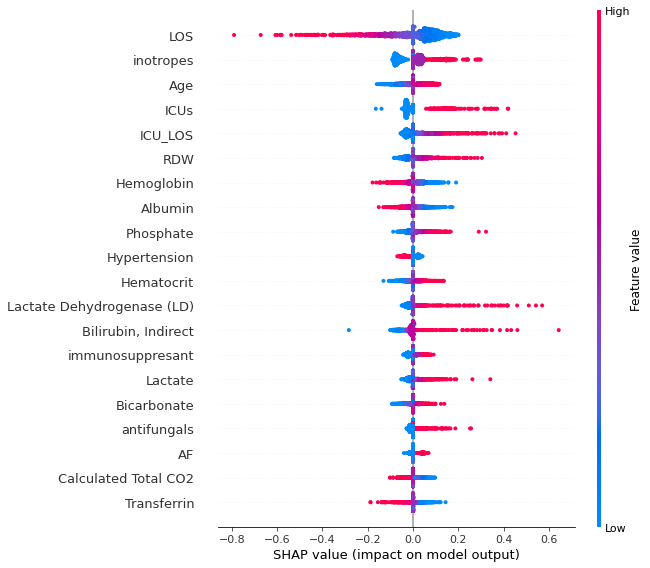

In [29]:
shap.summary_plot(shap_values[0], X_test)